In [77]:
#loading data

from preprocessing import read_consumption_data
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df = read_consumption_data()
df

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8
...,...,...,...,...
49489,2023-04-02 21:00:00,helsingfors,6.333000,-1.1
49490,2023-04-02 21:00:00,oslo,12.134655,-1.1
49491,2023-04-02 21:00:00,stavanger,5.622820,0.5
49492,2023-04-02 21:00:00,tromsø,2.018333,-2.5


## Baseline 

In [50]:
from sklearn.metrics import mean_squared_error


df["hour"] = df["time"].dt.strftime("%H")
df["weekday"] = df["time"].dt.day_name()
df["baseline_prediction"] = df.groupby(["location", "hour", "weekday"])["consumption"].shift(1)

df = df[~df["baseline_prediction"].isna()]

mape = np.mean(np.abs((df["consumption"] - df["baseline_prediction"]) / df["consumption"]))
rmse = np.sqrt(mean_squared_error(df["consumption"], df["baseline_prediction"]))
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


RMSE: 0.6811623559435133
MAPE: 0.1083910536600149


#### Making a color palette

In [78]:
# color palatte dictionary with the colors : "#31454A", "#4F8A86", "#D2AE8D", "#D79C82", "#C67A6C", "#C1C7C8"

colorpaldict = { "consumption": "#31454A", "sixth": "#3D5A63", "temperature": "#4F8A86", "third": "#D2AE8D", "fourth": "#D79C82", "fifth": "#C67A6C" }

#making for the cities, with Helsingfors being #C1C7C8
citydict = {"Helsingfors": "#C67A6C","Oslo": "#31454A", "Bergen": "#4F8A86", "Stavanger": "#D2AE8D", "Tromsø": "#D79C82", "Trondheim": "#3D5A63"}

## Consumption

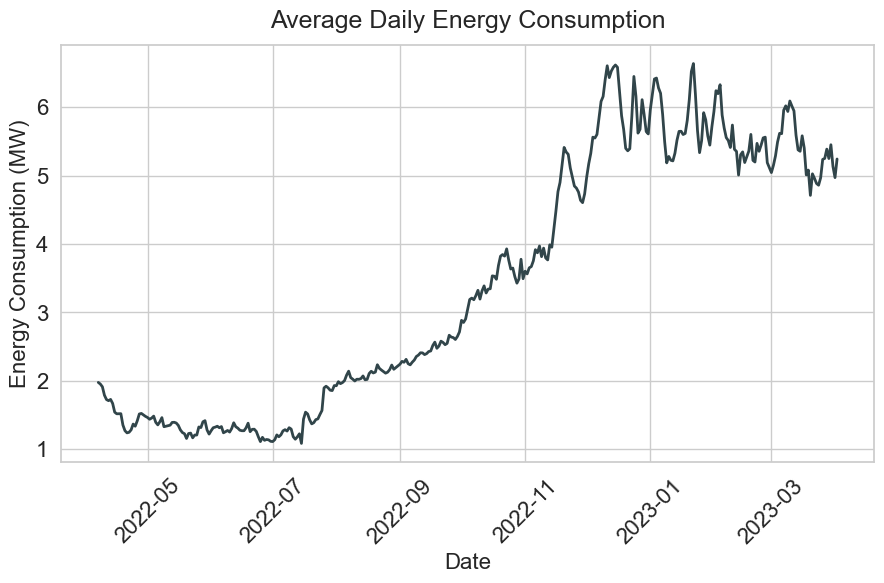

In [79]:
df = read_consumption_data()
# plotting the average daily consumption in the whole dataset
daily_avg_consumption= (
    df.groupby([df["time"].dt.date])["consumption"].mean()
)
# Set the Seaborn style
# sns.set(style="whitegrid")

# Create the Seaborn line plot
plt.figure(figsize=(9, 6))
sns.lineplot(x=daily_avg_consumption.index, y=daily_avg_consumption, color=colorpaldict["consumption"], linewidth=2)
plt.title("Average Daily Energy Consumption", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Date", fontname="Arial", fontsize=16)
plt.ylabel("Energy Consumption (MW)", fontname="Arial", fontsize=16)
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

#### Helsingfors Consumption

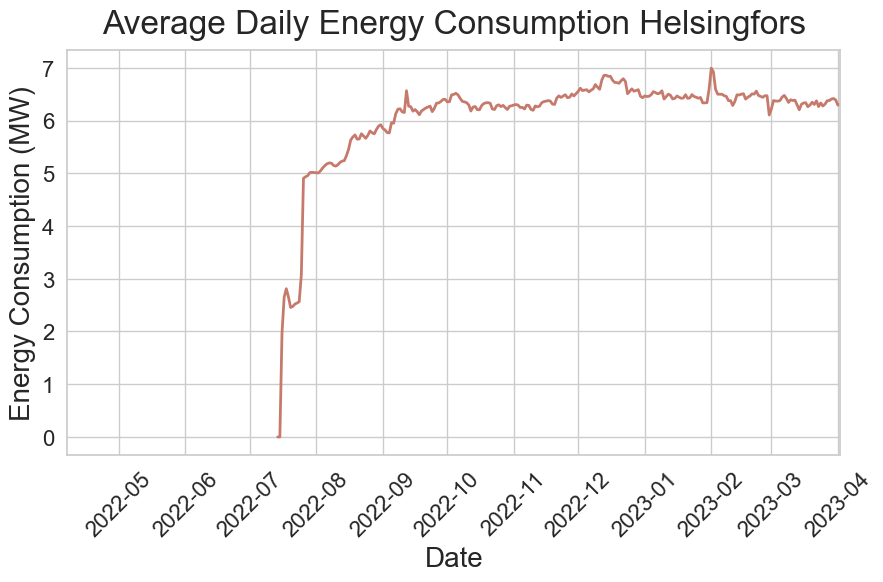

In [85]:

#plotting the consumption for Helsingfors:
df = read_consumption_data()
date_range = pd.date_range(start=df["time"].dt.date.min(), 
                          end=df["time"].dt.date.max())

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)


daily_avg_consumption_helsingfors = daily_avg_consumption.reindex(date_range)

plt.figure(figsize=(9, 6))
sns.lineplot(x=date_range, y=daily_avg_consumption_helsingfors["helsingfors"], color=citydict["Helsingfors"], linewidth=2)
plt.title("Average Daily Energy Consumption Helsingfors", fontname="Arial", fontsize=24, y=1.02)
plt.xlabel("Date", fontname="Arial", fontsize=20)
plt.ylabel("Energy Consumption (MW)", fontname="Arial", fontsize=20)
plt.grid(True)

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.xlim(date_range.min(), date_range.max())
plt.tight_layout()
plt.show()

#### Consumption all cities

location      bergen  helsingfors      oslo  stavanger    tromsø  trondheim
time                                                                       
2022-04-07  1.057482          NaN  3.857302   1.932868  1.188618   1.852405
2022-04-08  1.025314          NaN  3.844801   1.866316  1.156766   1.875748
2022-04-09  1.097857          NaN  3.689813   1.885124  1.092602   1.804450
2022-04-10  1.080573          NaN  3.254670   1.753968  1.086494   1.776716
2022-04-11  1.034815          NaN  3.100625   1.643581  1.061387   1.793448


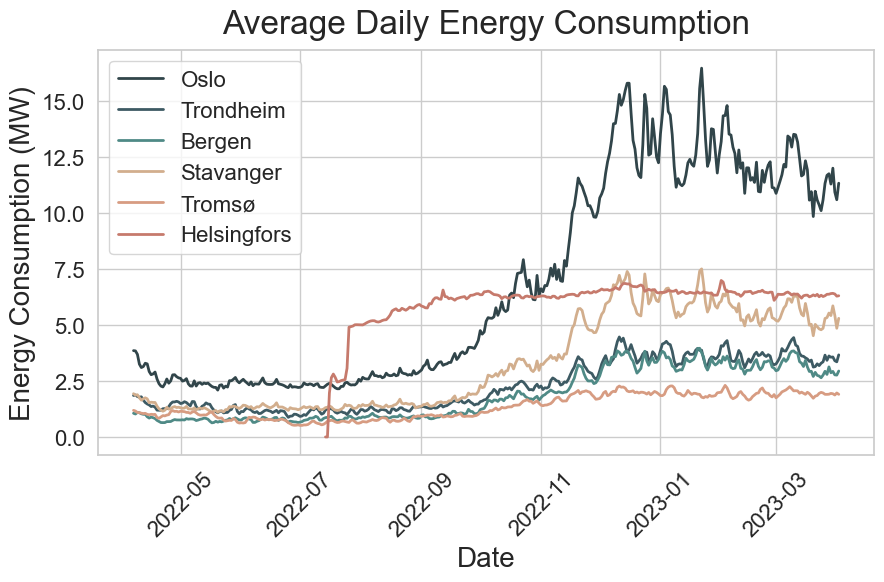

In [84]:
# Plotting average consumprtion for all cities:



daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)
print(daily_avg_consumption.head())
# sort by cities in order: oslo, trondheim, bergen, stavanger, tromso, helsingfors
daily_avg_consumption = daily_avg_consumption[["oslo", "trondheim", "bergen", "stavanger", "tromsø", "helsingfors"]]
plt.figure(figsize=(9, 6))
for city in daily_avg_consumption.columns:
    sns.lineplot(x=daily_avg_consumption.index, y=daily_avg_consumption[city], label = city.capitalize(), color = citydict[city.capitalize()], linewidth=2)
plt.title("Average Daily Energy Consumption", fontname="Arial", fontsize=24, y=1.02)
plt.xlabel("Date", fontname="Arial", fontsize=20)
plt.ylabel("Energy Consumption (MW)", fontname="Arial", fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()

#### Consumption and temperature Season

In [86]:
# Function defining what season a datapoint belongs to 
def get_season(month, day):
    if  month == 3 or month == 4 or month == 5:
        return 'Spring'
    elif month == 6 or month == 7 or month == 8:
        return 'Summer'
    elif month == 9 or month == 10 or month == 11:
        return 'Fall'
    else:
        return 'Winter'


#adding season coloumn
df['season'] = df.apply(lambda row: get_season(row['time'].month, row['time'].day), axis=1)


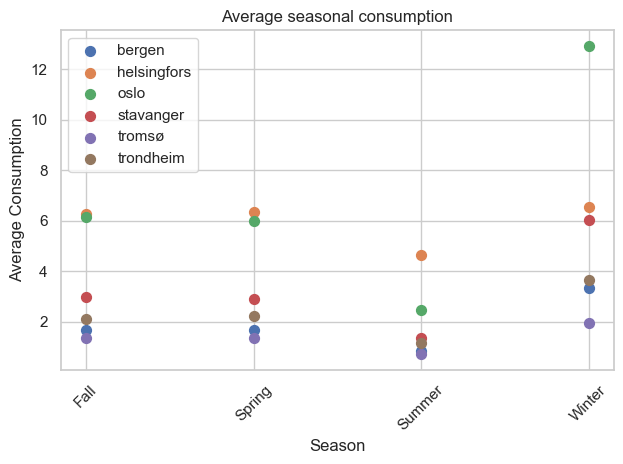

In [56]:
# Plotting average consumption for the cities based on what season it is:
season_avg_consumption= (
    df.groupby([df["season"], "location"])["consumption"].mean().unstack()
)

for city in season_avg_consumption.columns:
    plt.scatter(season_avg_consumption.index, season_avg_consumption[city], label = city, marker='o', s=50)
plt.title("Average seasonal consumption")
plt.xlabel("Season")
plt.ylabel("Average Consumption")
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

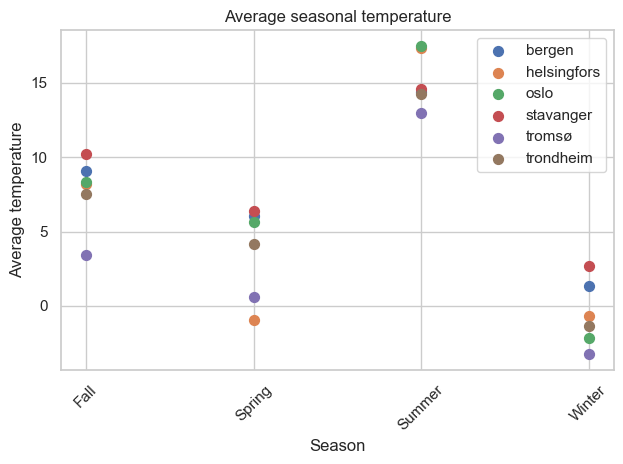

In [57]:
# Plotting average consumption for the cities based on what season it is:
season_avg_temperature= (
    df.groupby([df["season"], "location"])["temperature"].mean().unstack()
)

# print(season_avg_temperature.loc["Spring"].tolist())

# print(season_avg_temperature.head())


# Create a scatter plot for each city
for city in season_avg_temperature.columns:
    plt.scatter(season_avg_temperature.index, season_avg_temperature[city], label = city, marker='o', s=50)

# Set x-axis labels to be the seasons

plt.title("Average seasonal temperature")
plt.xlabel("Season")
plt.ylabel("Average temperature")
plt.legend()
# plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# df.drop("season", axis=1, inplace=True)




#### Average temperature


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


time
2022-04-07   -1.273333
2022-04-08    1.072500
2022-04-09    2.996667
2022-04-10    3.830000
2022-04-11    3.642500
Name: temperature, dtype: float64


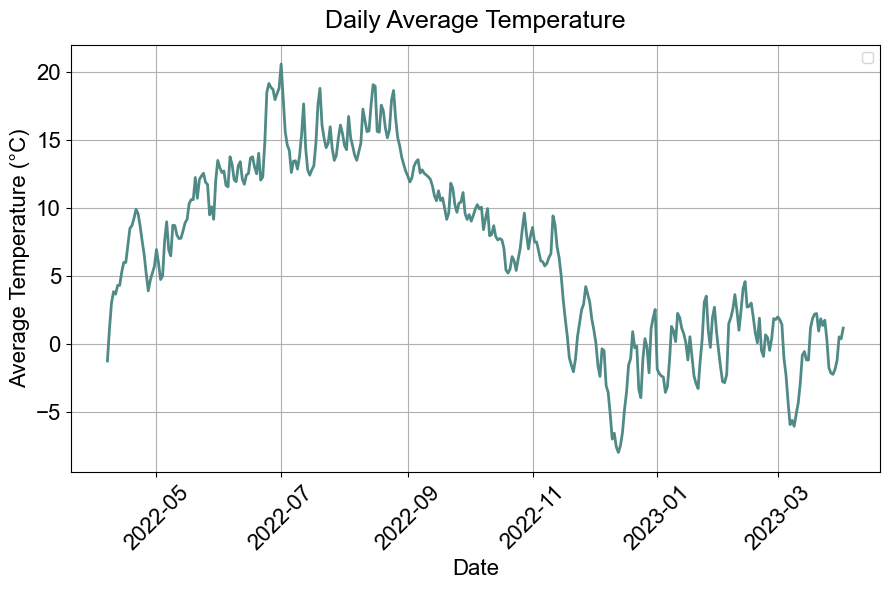

In [9]:
#plotting the daily average temperature for thw whole period
daily_avg_temp_overall = (
    df.groupby([df["time"].dt.date])["temperature"].mean()
)
# Loop through each city and plot its daily average temperature

print(daily_avg_temp_overall.head())
plt.figure(figsize=(9, 6))
sns.lineplot(x = daily_avg_temp_overall.index, y = daily_avg_temp_overall, color=colorpaldict["temperature"], linewidth=2)

# Customize the plot
plt.title("Daily Average Temperature", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Date",  fontname="Arial", fontsize=16)
plt.ylabel(f"Average Temperature (\u00b0C)", fontname="Arial", fontsize=16)
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()



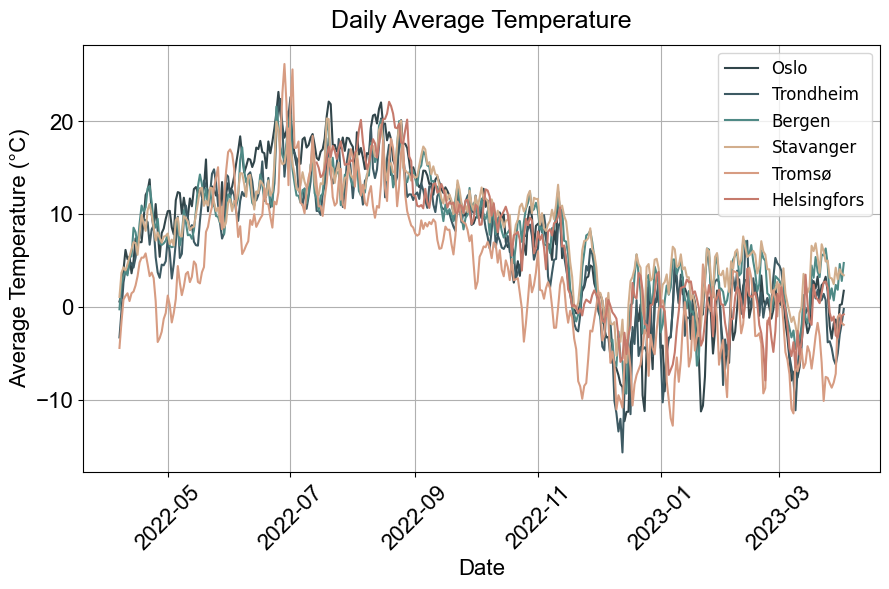

In [10]:
#plotting the daily average temperature for thw whole period
daily_avg_temp = (
    df.groupby([df["time"].dt.date, "location"])["temperature"].mean().unstack()
)
# Loop through each city and plot its daily average temperature
daily_avg_temp = daily_avg_temp[["oslo", "trondheim", "bergen", "stavanger", "tromsø", "helsingfors"]]
plt.figure(figsize=(9, 6))
for city in daily_avg_temp.columns:
    sns.lineplot(x = daily_avg_temp.index, y = daily_avg_temp[city], label = city.capitalize(), color = citydict[city.capitalize()])

# Customize the plot
plt.title("Daily Average Temperature", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Date",  fontname="Arial", fontsize=16)
plt.ylabel(f"Average Temperature (\u00b0C)", fontname="Arial", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()



#### Normalized average temperature vs. normalized consumption

In [87]:
df = read_consumption_data()

#removing helsingfors

# df = df[df["location"] != "helsingfors"]


scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

#normalizing temperature overall
df['Temperature_Normalized'] = scaler1.fit_transform(df['temperature'].values.reshape(-1, 1))
#normalizing consumption within each city
df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])

print("The total correlation between temperature and consumption is: ", df["Temperature_Normalized"].corr(df["Consumption_Normalized"]))

df.drop("temperature", inplace=True, axis=1)
df.drop("consumption", inplace=True, axis=1)

# df.head()


The total correlation between temperature and consumption is:  -0.7209414846548814


C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2075808547.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2075808547.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2075808547.py:14: DeprecationWarning: Conversi

location      bergen  helsingfors      oslo  stavanger    tromsø  trondheim
time                                                                       
2022-04-07  0.356346          NaN  0.373780   0.384240  0.269177   0.292887
2022-04-08  0.412744          NaN  0.390342   0.438808  0.327842   0.352075
2022-04-09  0.431921          NaN  0.445084   0.450750  0.378400   0.416928
2022-04-10  0.443950          NaN  0.490324   0.444125  0.386593   0.445258
2022-04-11  0.432967          NaN  0.469404   0.458333  0.392434   0.437500
...              ...          ...       ...        ...       ...        ...
2023-03-29  0.411437     0.297420  0.333333   0.450227  0.211036   0.231695
2023-03-30  0.400366     0.292451  0.304480   0.423727  0.338476   0.256712
2023-03-31  0.458595     0.317643  0.366196   0.446740  0.345624   0.299773
2023-04-01  0.420328     0.342312  0.367591   0.436192  0.324965   0.324965
2023-04-02  0.460822     0.344808  0.398155   0.433245  0.321225   0.357075

[361 rows x

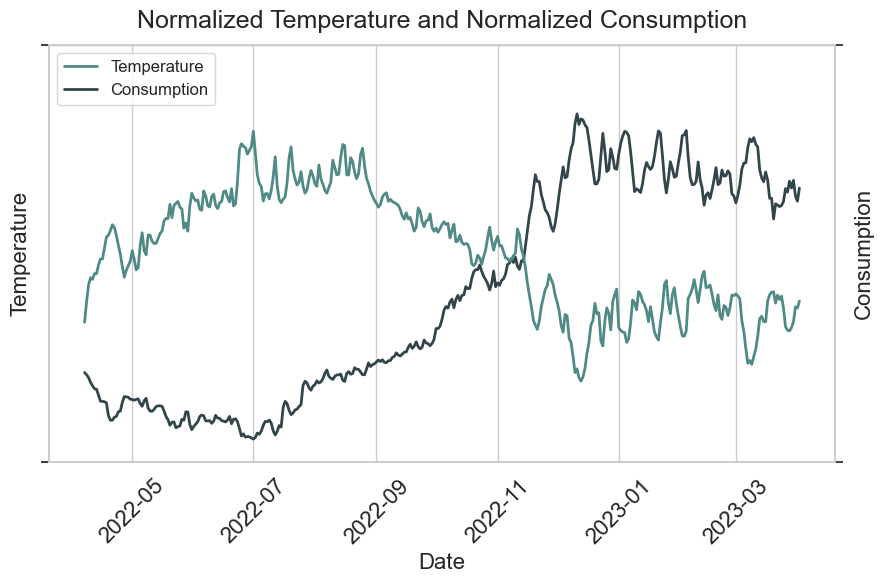

In [88]:
# making daily avg plots

#dropping helsingfors
from matplotlib.lines import Line2D


# df = df[df["location"] != "helsingfors"]


daily_avg_temp = (
    df.groupby([df["time"].dt.date, "location"])["Temperature_Normalized"].mean().unstack()
)

print(daily_avg_temp)



# Create custom legend labels
labels = ['Temperature', 'Consumption']

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["Consumption_Normalized"].mean().unstack()
)

#taking the average normalized consumption per city
daily_avg_consumption_avg_cities = (
    df.groupby([df["time"].dt.date])["Consumption_Normalized"].mean()
)
daily_avg_temp_avg_cities = (
    df.groupby([df["time"].dt.date])["Temperature_Normalized"].mean()
)
plt.figure(figsize=(9, 6))
# Your existing code...

# Create custom legend labels
# labels = ['Temperature', 'Consumption']

# Your existing code...

# Plot the lines outside the loop
sns.lineplot(x=daily_avg_consumption_avg_cities.index, y=daily_avg_consumption_avg_cities, color=colorpaldict["consumption"], label="Consumption", linewidth=2)
sns.lineplot(x=daily_avg_temp_avg_cities.index, y=daily_avg_temp_avg_cities, color=colorpaldict["temperature"], label="Temperature", linewidth=2)

# set the title of the plot
plt.title("Normalized Temperature and Normalized Consumption", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Date", fontname="Arial", fontsize=16)

# make  y axis label for temperature and consumption
ax = plt.gca()
ax2 = ax.twinx()
ax.set_ylabel("Temperature", fontname="Arial", fontsize=16)
ax2.set_ylabel("Consumption", fontname="Arial", fontsize=16)

# set y range for both y axis to 0,1
y_range = range(0, 2)
ax.set_yticks(y_range)
ax2.set_yticks(y_range)

# hide numbers on the y axis but keep ticks and make horizontal grid for both y axis
ax2.yaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax2.grid(True)
ax.grid(True)

# make x axis label rotate 45 degrees and font size 16 and arial
ax.xaxis.set_tick_params(rotation=45, labelsize=16, labelfontfamily="Arial")
ax2.xaxis.set_tick_params(rotation=45, labelsize=16, labelfontfamily="Arial")

for label in ax.get_xticklabels():
    label.set_fontproperties({"family":"Arial", "size":16})

for label in ax.get_yticklabels():
    label.set_fontproperties({"family":"Arial" , "size":16})

# Create custom legend
custom_lines = [Line2D([0], [0], color=colorpaldict["temperature"], lw=2),
                Line2D([0], [0], color=colorpaldict["consumption"], lw=2)]
ax.legend(custom_lines, labels, fontsize=12, loc="upper left")

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()




# # Customize the plot
# plt.title("Normalized Temperature and Normalized Consumption", fontname="Arial", fontsize=18, y=1.02)
# plt.xlabel("Date", fontname="Arial", fontsize=16)

# # Left y label for temperature and right y label for consumption
# ax = plt.gca()
# ax2 = ax.twinx()
# ax.set_ylabel("Temperature", fontname="Arial", fontsize=16)
# ax2.set_ylabel("Consumption", fontname="Arial", fontsize=16)

# y_range = range(0, int(max(max(daily_avg_temp_avg_cities), max(daily_avg_consumption_avg_cities))) + 1)
# ax.set_yticks(y_range)
# ax2.set_yticks(y_range)

# # Hide numbers on y axis but keep ticks and make horizontal grid for both y axis
# ax2.yaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# ax2.grid(True)
# ax.grid(True)

# ax.xaxis.set_tick_params(rotation=45, labelsize=16, labelfontfamily="Arial")



# # Create custom legend
# custom_lines = [Line2D([0], [0], color=colorpaldict["temperature"], lw=2),
#                 Line2D([0], [0], color=colorpaldict["consumption"], lw=2)]
# ax.legend(custom_lines, labels, fontsize=12, loc="upper left")
# #make the font on the legend arial


# # make x axis label rotate 45 degrees and font size 16 and arial
# plt.xticks(fontname="Arial", fontsize=16)
# plt.yticks(fontname="Arial", fontsize=16)
# plt.show()



C:\Users\siver\AppData\Local\Temp\ipykernel_27772\1662379002.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([df["season"], "location"])["Temperature_Normalized"].mean().unstack()
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\1662379002.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([df["season"], "location"])["Consumption_Normalized"].mean().unstack()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


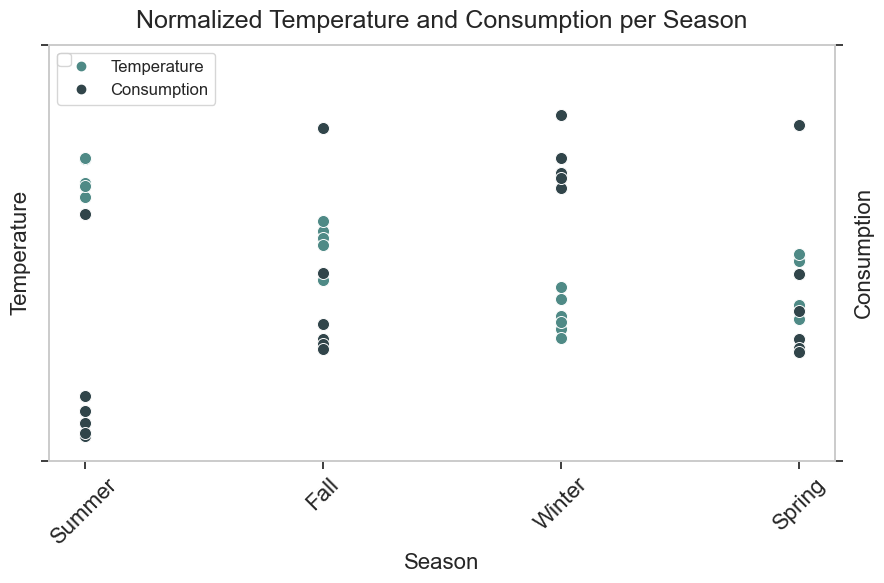

In [102]:
# doing same but seasonal


df['season'] = df.apply(lambda row: get_season(row['time'].month, row['time'].day), axis=1)

custom_season_order = ['Summer', 'Fall', 'Winter', 'Spring']

# Convert the 'season' column to a categorical data type with the custom order
df['season'] = pd.Categorical(df['season'], categories=custom_season_order, ordered=True)

season_avg_temperature= (
    df.groupby([df["season"], "location"])["Temperature_Normalized"].mean().unstack()
)

# season_avg_temperature = season_avg_temperature[["Summer", "Fall", "Winter", "Spring"]]

season_avg_consumption= (
    df.groupby([df["season"], "location"])["Consumption_Normalized"].mean().unstack()
)
# season_avg_consumption = season_avg_consumption[["Summer", "Fall", "Winter", "Spring"]]
# Create custom legend handles

plt.figure(figsize=(9, 6))

i=0
# plt.figure(figsize=(6, 6))
for city in season_avg_temperature.columns:
    if i==0:
        sns.scatterplot(x=season_avg_temperature.index, y=season_avg_temperature[city], label="Temperature", marker='o', s=75, color=colorpaldict["temperature"])
    else:
        sns.scatterplot(x=season_avg_temperature.index, y=season_avg_temperature[city], marker='o', s=75,  color=colorpaldict["temperature"])
    i+=1

i = 0
for city in season_avg_consumption.columns:
    if i==0:
        sns.scatterplot(x=season_avg_consumption.index, y=season_avg_consumption[city], label="Consumption", marker='o', s=75, color=colorpaldict["consumption"])
    else:
        sns.scatterplot(x=season_avg_consumption.index, y=season_avg_consumption[city], marker='o', s=75, color=colorpaldict["consumption"])
    i+=1


        
plt.title("Normalized Temperature and Consumption per Season", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Season", fontname="Arial", fontsize=16)
ax = plt.gca()
ax2 = ax.twinx()
ax.set_ylabel("Temperature", fontname="Arial", fontsize=16)
ax2.set_ylabel("Consumption", fontname="Arial", fontsize=16)
y_range = range(0, 2)
ax.set_yticks(y_range)
ax2.set_yticks(y_range)
#hide numbers on y axis
ax2.set_yticklabels([])
ax.set_yticklabels([])
plt.legend(loc="upper left", fontsize=12)

# make x axis label rotate 45 degrees and font size 16 and arial
ax.xaxis.set_tick_params(rotation=45, labelsize=16, labelfontfamily="Arial")
ax2.xaxis.set_tick_params(rotation=45, labelsize=16, labelfontfamily="Arial")
for label in ax.get_xticklabels():
    label.set_fontproperties({"family":"Arial", "size":16})

for label in ax.get_yticklabels():
    label.set_fontproperties({"family":"Arial" , "size":16})

#make the x-ticks appear on the bottom
ax.xaxis.set_ticks_position('bottom')



# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.tight_layout()

# make custom legend with circles
custom_lines = [Line2D([0], [0], marker='o', color=colorpaldict["temperature"], lw=0),
                Line2D([0], [0], marker='o', color=colorpaldict["consumption"], lw=0)]
ax.legend(custom_lines, labels, fontsize=12, loc="upper left")

# make the x ticks for summer, fall, winter, spring
plt.xticks(range(0, 4), custom_season_order)





#remove grids
ax.grid(False)
ax2.grid(False)
plt.show()

#### Correlation between temperature and consumption in each city

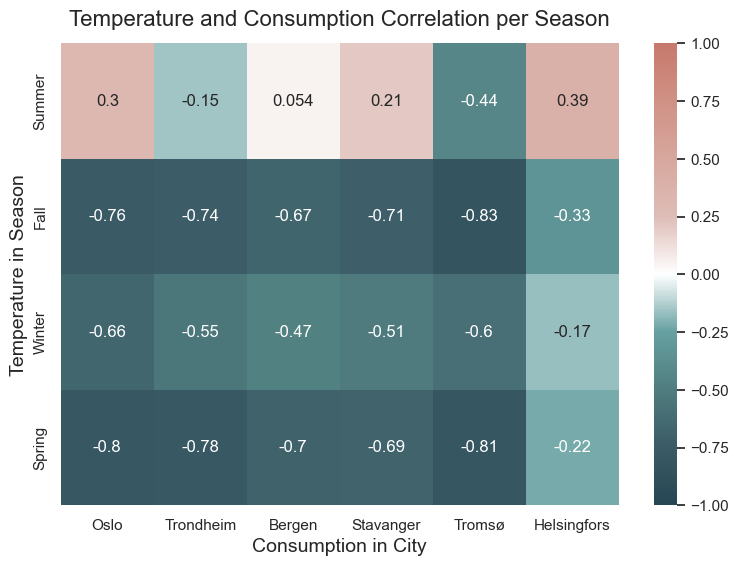

In [108]:

#finding correlation between temperature and consumption in each location

#oslo
oslo_fall = df[(df["location"] == "oslo") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Fall")]["Consumption_Normalized"])
oslo_spring = df[(df["location"] == "oslo") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Spring")]["Consumption_Normalized"])
oslo_summer = df[(df["location"] == "oslo") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Summer")]["Consumption_Normalized"])
oslo_winter = df[(df["location"] == "oslo") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Winter")]["Consumption_Normalized"])

#trondheim
trondheim_fall = df[(df["location"] == "trondheim") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Fall")]["Consumption_Normalized"])
trondheim_spring = df[(df["location"] == "trondheim") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Spring")]["Consumption_Normalized"])
trondheim_summer = df[(df["location"] == "trondheim") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Summer")]["Consumption_Normalized"])
trondheim_winter = df[(df["location"] == "trondheim") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Winter")]["Consumption_Normalized"])

#bergen
bergen_fall = df[(df["location"] == "bergen") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Fall")]["Consumption_Normalized"])
bergen_spring = df[(df["location"] == "bergen") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Spring")]["Consumption_Normalized"])
bergen_summer = df[(df["location"] == "bergen") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Summer")]["Consumption_Normalized"])
bergen_winter = df[(df["location"] == "bergen") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Winter")]["Consumption_Normalized"])

#stavanger
stavanger_fall = df[(df["location"] == "stavanger") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Fall")]["Consumption_Normalized"])
stavanger_spring = df[(df["location"] == "stavanger") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Spring")]["Consumption_Normalized"])
stavanger_summer = df[(df["location"] == "stavanger") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Summer")]["Consumption_Normalized"])
stavanger_winter = df[(df["location"] == "stavanger") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Winter")]["Consumption_Normalized"])

#tromsø
tromsø_fall = df[(df["location"] == "tromsø") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Fall")]["Consumption_Normalized"])
tromsø_spring = df[(df["location"] == "tromsø") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Spring")]["Consumption_Normalized"])
tromsø_summer = df[(df["location"] == "tromsø") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Summer")]["Consumption_Normalized"])
tromsø_winter = df[(df["location"] == "tromsø") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Winter")]["Consumption_Normalized"])

#helsingfors
helsingfors_fall = df[(df["location"] == "helsingfors") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "helsingfors") & (df["season"] == "Fall")]["Consumption_Normalized"])
helsingfors_spring = df[(df["location"] == "helsingfors") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "helsingfors") & (df["season"] == "Spring")]["Consumption_Normalized"])
helsingfors_summer = df[(df["location"] == "helsingfors") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "helsingfors") & (df["season"] == "Summer")]["Consumption_Normalized"])
helsingfors_winter = df[(df["location"] == "helsingfors") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "helsingfors") & (df["season"] == "Winter")]["Consumption_Normalized"])


# making a heatmao with each season on the x axis and each city on the y axis
# Oslo
oslo = [oslo_summer, oslo_fall, oslo_winter, oslo_spring]
# Trondheim
trondheim = [trondheim_summer, trondheim_fall, trondheim_winter, trondheim_spring]
# Bergen
bergen = [bergen_summer, bergen_fall, bergen_winter, bergen_spring]
# Stavanger
stavanger =   [stavanger_summer, stavanger_fall, stavanger_winter, stavanger_spring]
# Tromsø
tromsø = [tromsø_summer, tromsø_fall, tromsø_winter, tromsø_spring]
#Helisngfors
helsingfors = [helsingfors_summer, helsingfors_fall, helsingfors_winter, helsingfors_spring]

#making a dataframe with all the values
data = {'Oslo': oslo, 'Trondheim': trondheim, 'Bergen': bergen, 'Stavanger': stavanger, 'Tromsø': tromsø, 'Helsingfors': helsingfors}
new_df = pd.DataFrame(data, index =['Summer', 'Fall', 'Winter', 'Spring'])

#making heatmap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colormap as a list of colors
colors = ["#264653", "#3B5B66", "#507D7F", "#66A0A1", "#FFFFFF", "#DEBDB7", "#D7A79E", "#D09185", "#C67A6C"]


# colors = ["#264653", "#3B5B66", "#507D7F", "#66A0A1", "#FFFFFF", "#E5D4D0", "#DEBDB7", "#D7A79E", "#D09185", "#C67A6C"]

# Create a ListedColormap from your custom colors
# custom_cmap = ListedColormap(colors)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
#scale colors y axis go from-1 to 1

plt.figure(figsize=(9, 6))
sns.heatmap(new_df, annot=True, cmap=custom_cmap, vmin=-1, vmax=1)
plt.title("Temperature and Consumption Correlation per Season", fontname="Arial", fontsize=16, y=1.02)
plt.xlabel("Consumption in City", fontname="Arial", fontsize=14)
plt.ylabel("Temperature in Season", fontname="Arial", fontsize=14)
plt.show()


# #printing out all values in table
# print("Correlation between temperature and consumption in each city during each season")
# print("Oslo: ")
# print("Fall: ", oslo_fall)
# print("Spring: ", oslo_spring)
# print("Summer: ", oslo_summer)
# print("Winter: ", oslo_winter)
# print()
# print("Trondheim: ")
# print("Fall: ", trondheim_fall)
# print("Spring: ", trondheim_spring)
# print("Summer: ", trondheim_summer)
# print("Winter: ", trondheim_winter)
# print()
# print("Bergen: ")
# print("Fall: ", bergen_fall)
# print("Spring: ", bergen_spring)
# print("Summer: ", bergen_summer)
# print("Winter: ", bergen_winter)
# print()
# print("Stavanger: ")
# print("Fall: ", stavanger_fall)
# print("Spring: ", stavanger_spring)
# print("Summer: ", stavanger_summer)
# print("Winter: ", stavanger_winter)
# print()
# print("Tromsø: ")
# print("Fall: ", tromsø_fall)
# print("Spring: ", tromsø_spring)
# print("Summer: ", tromsø_summer)
# print("Winter: ", tromsø_winter)
# print()


#### Violin plots


C:\Users\siver\AppData\Local\Temp\ipykernel_27772\1562150647.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df["time"].dt.month_name(), y=df["consumption"], palette=smooth_palette)


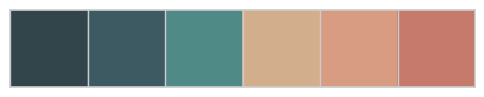

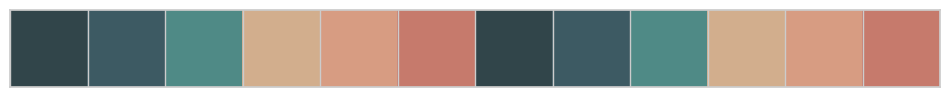

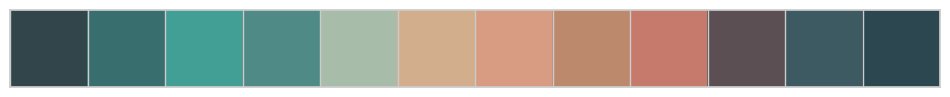

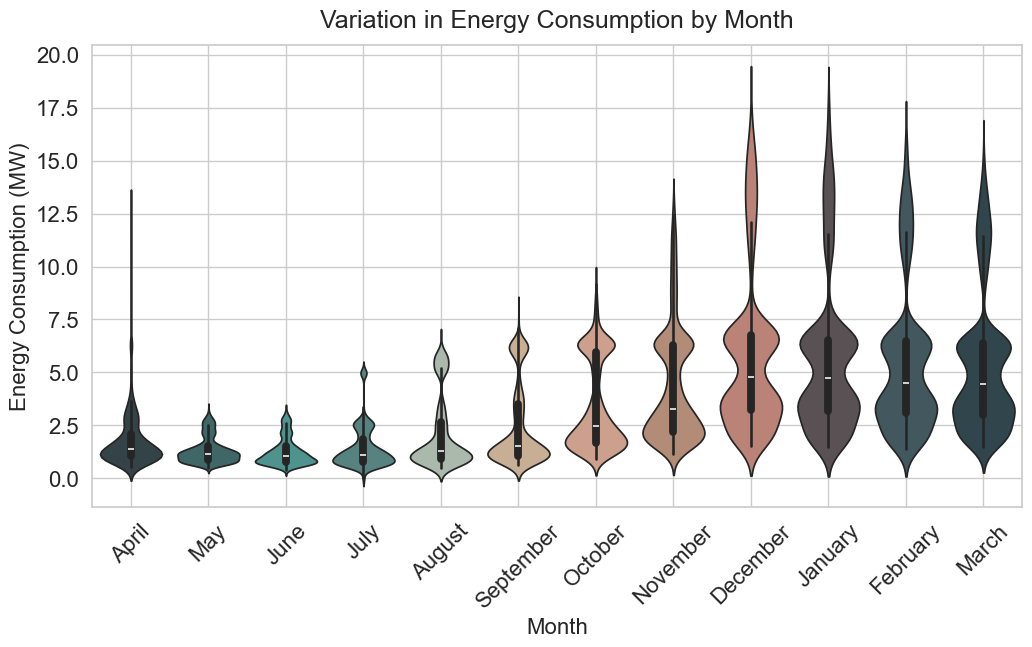

In [110]:
df = read_consumption_data()
# Define a custom color palette
custom_palette = ["#31454A", "#3D5A63", "#4F8A86", "#D2AE8D", "#D79C82", "#C67A6C" ]
sns.palplot(custom_palette)

interpolated_palette = sns.color_palette(custom_palette, n_colors=12)
sns.palplot(interpolated_palette)

smooth_palette = [
    "#31454A", "#386E6D", "#429F96", "#4F8A86", 
    "#A7BCA9", "#D2AE8D", "#D79C82", "#BD896D","#C67A6C",  
     "#5C4F53",  "#3D5A63", "#2D4750"
]
sns.palplot(smooth_palette)


# Create a violin plot to visualize the variation in energy consumption
plt.figure(figsize=(12, 6))
sns.violinplot(x=df["time"].dt.month_name(), y=df["consumption"], palette=smooth_palette)
plt.title("Variation in Energy Consumption by Month", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Month", fontname="Arial", fontsize=16)
plt.ylabel("Energy Consumption (MW)", fontname="Arial", fontsize=16)
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.grid(True)
plt.show()



C:\Users\siver\AppData\Local\Temp\ipykernel_27772\1533103237.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df["time"].dt.month_name(), y=df["temperature"], palette=smooth_palette)


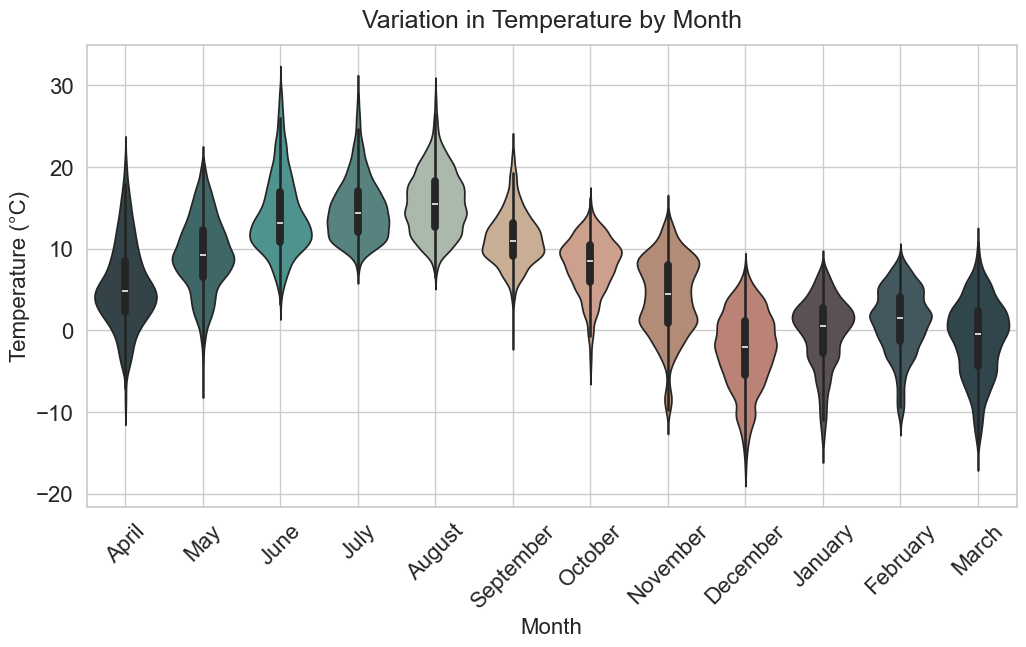

In [111]:
# Define a custom color palette
custom_palette = ["#31454A", "#3D5A63", "#4F8A86", "#D2AE8D", "#D79C82", "#C67A6C" ]

smooth_palette = [
    "#31454A", "#386E6D", "#429F96", "#4F8A86", 
    "#A7BCA9", "#D2AE8D", "#D79C82", "#BD896D","#C67A6C", 
     "#5C4F53",  "#3D5A63", "#2D4750"
]



# Create a violin plot to visualize the variation in energy consumption
plt.figure(figsize=(12, 6))
sns.violinplot(x=df["time"].dt.month_name(), y=df["temperature"], palette=smooth_palette)
plt.title("Variation in Temperature by Month", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Month", fontname="Arial", fontsize=16)
plt.ylabel(f"Temperature (\u00b0C)", fontname="Arial", fontsize=16)
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.grid(True)
plt.show()

C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2579857761.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='location', y='consumption', palette=custom_palette)


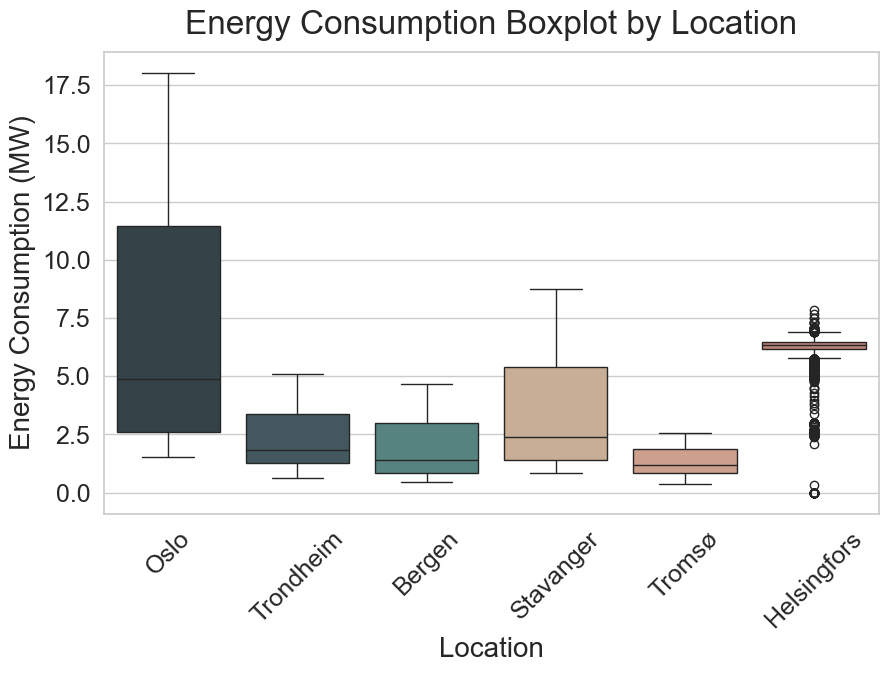

In [116]:
# Define the desired order of cities
city_order = ['Oslo', 'Trondheim', 'Bergen', 'Stavanger', 'Tromsø', 'Helsingfors']

# convert location colum to have capital first letter
df['location'] = df['location'].str.capitalize()

# Sort locations based on the desired order

df['location'] = pd.Categorical(df['location'], categories=city_order, ordered=True)


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Optional style setting

sns.boxplot(data=df, x='location', y='consumption', palette=custom_palette)

# Set labels and title
plt.xlabel("Location", fontname="Arial", fontsize=20)
plt.ylabel("Energy Consumption (MW)", fontname="Arial", fontsize=20)
plt.title("Energy Consumption Boxplot by Location", fontname="Arial", fontsize=24, y=1.02)
plt.xticks(rotation=45, fontname="Arial", fontsize=18)
plt.yticks(fontname="Arial", fontsize=18)

# Show the plot
plt.show()

C:\Users\siver\AppData\Local\Temp\ipykernel_27772\767604595.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='location', y='temperature', palette=custom_palette)


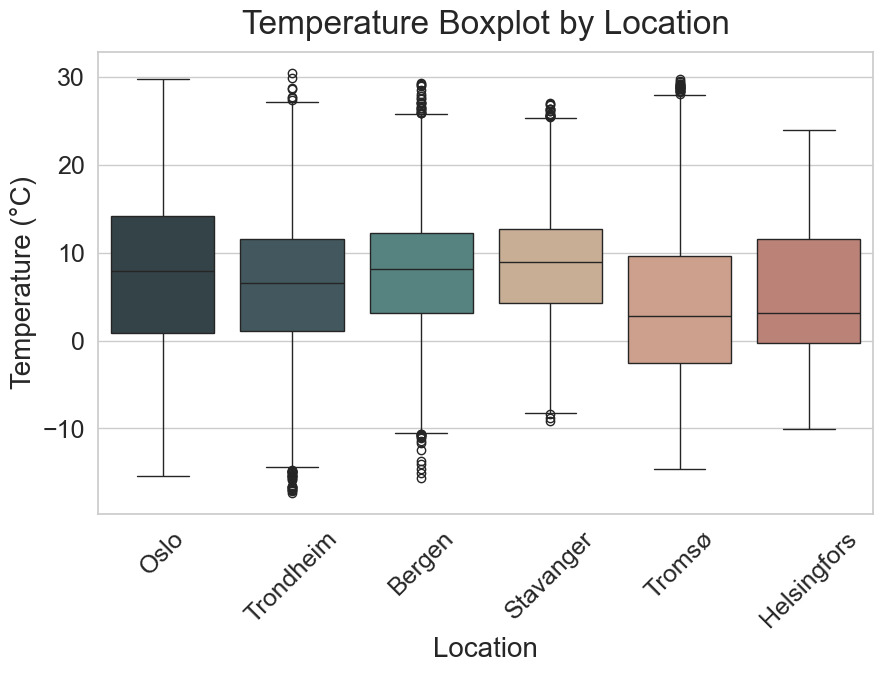

In [118]:
# Define the desired order of cities
city_order = ['Oslo', 'Trondheim', 'Bergen', 'Stavanger', 'Tromsø', 'Helsingfors']

# convert location colum to have capital first letter
df['location'] = df['location'].str.capitalize()

# Sort locations based on the desired order

df['location'] = pd.Categorical(df['location'], categories=city_order, ordered=True)


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Optional style setting

sns.boxplot(data=df, x='location', y='temperature', palette=custom_palette)

# Set labels and title
plt.xlabel("Location", fontname="Arial", fontsize=20)
plt.ylabel(f"Temperature (\u00b0C)", fontname="Arial", fontsize=20)
plt.title("Temperature Boxplot by Location", fontname="Arial", fontsize=24, y=1.02)
plt.xticks(rotation=45, fontname="Arial", fontsize=18)
plt.yticks(fontname="Arial", fontsize=18)

# Show the plot
plt.show()

Average temperature per weekday

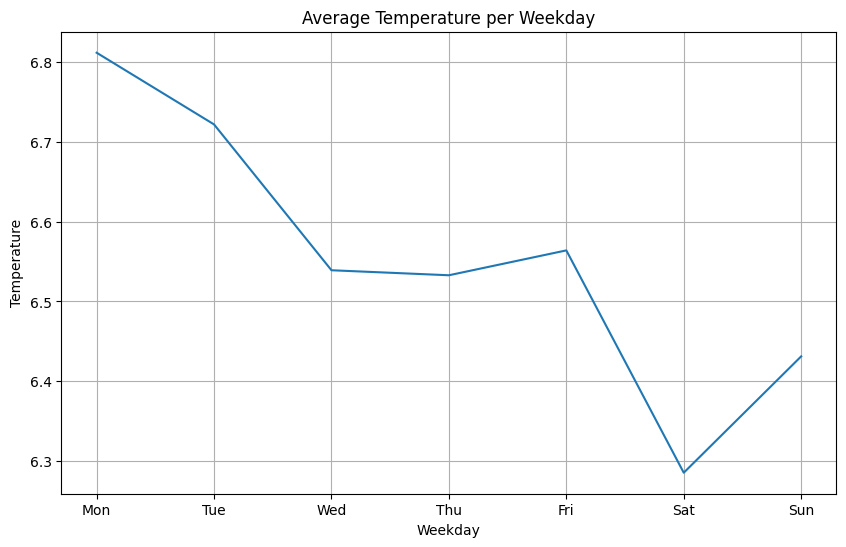

In [31]:
df = read_consumption_data()
# create a weekday column
df['weekday'] = df['time'].dt.weekday
# group on weekdays and find average temperature per weekday
weekday_avg_temp = df.groupby('weekday')['temperature'].mean().reset_index()
# plot the average temperature per weekday as a line plot
plt.figure(figsize=(10, 6))
plt.plot(weekday_avg_temp['weekday'], weekday_avg_temp['temperature'])
plt.title('Average Temperature per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Temperature')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()


## Weekday trends

C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2353747097.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler4.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2353747097.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler4.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2353747097.py:14: DeprecationWarning: Conversi

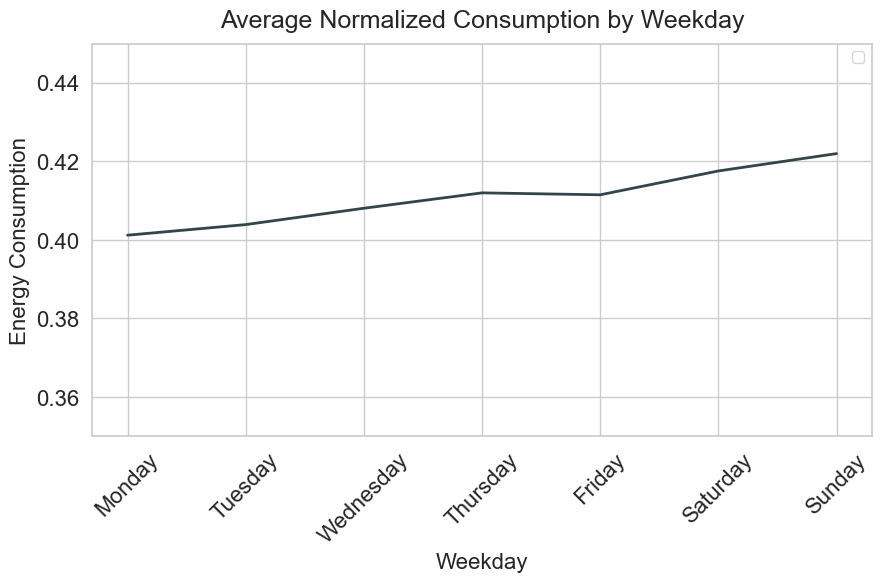

In [40]:
df = read_consumption_data()

#removing helsingfors

# df = df[df["location"] != "helsingfors"]


scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()

#normalizing temperature overall
df['Temperature_Normalized'] = scaler3.fit_transform(df['temperature'].values.reshape(-1, 1))
#normalizing consumption within each city
df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler4.fit_transform(x.values.reshape(-1, 1))])

df.drop("temperature", inplace=True, axis=1)
df.drop("consumption", inplace=True, axis=1)

# Extract the "weekday" column using dt.day_name() and sort it based on your custom order
df["weekday"] = df["time"].dt.day_name()
custom_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=custom_order, ordered=True)

# Group by "weekday" and "location" and calculate the mean consumption
weekday_avg_consumption = df.groupby(["weekday"])["Consumption_Normalized"].mean()


# Plot the data
plt.figure(figsize=(9, 6))

sns.lineplot(x=weekday_avg_consumption.index, y=weekday_avg_consumption, color="#31454A", linewidth=2)

plt.title("Average Normalized Consumption by Weekday", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Weekday", fontname="Arial", fontsize=16)
plt.ylabel("Energy Consumption", fontname="Arial", fontsize=16)
plt.legend()

# Set y-axis limits from 0 to 1
plt.ylim(0.35, 0.45)
plt.grid(True)

# Display the plot
plt.xticks(rotation=45, fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()

## hourly trend

C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2624457426.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler6.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2624457426.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler6.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_27772\2624457426.py:14: DeprecationWarning: Conversi

The total correlation between temperature and consumption is:  -0.7209414846548814


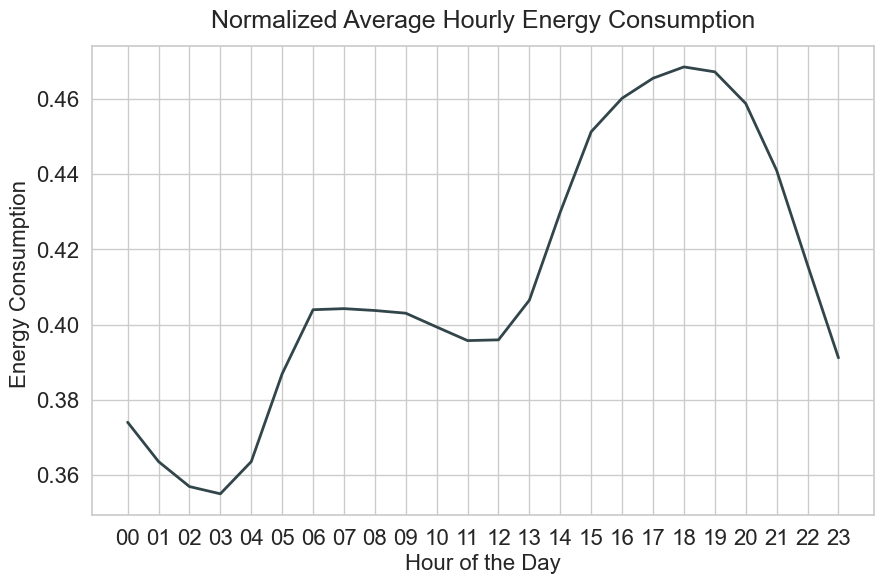

In [41]:
df = read_consumption_data()

#removing helsingfors

# df = df[df["location"] != "helsingfors"]


scaler5 = MinMaxScaler()
scaler6 = MinMaxScaler()

#normalizing temperature overall
df['Temperature_Normalized'] = scaler5.fit_transform(df['temperature'].values.reshape(-1, 1))
#normalizing consumption within each city
df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler6.fit_transform(x.values.reshape(-1, 1))])

print("The total correlation between temperature and consumption is: ", df["Temperature_Normalized"].corr(df["Consumption_Normalized"]))

df.drop("temperature", inplace=True, axis=1)
df.drop("consumption", inplace=True, axis=1)

# Extract the "hour" column from the "time" column
df["hour"] = df["time"].dt.strftime("%H")

# Group by "hour" and calculate the mean consumption
hourly_avg_consumption = df.groupby("hour")["Consumption_Normalized"].mean()

# Plot the average hourly energy consumption for all hours
plt.figure(figsize=(9, 6))
sns.lineplot(x=hourly_avg_consumption.index, y=hourly_avg_consumption.values, color="#31454A", linewidth=2)

plt.title("Normalized Average Hourly Energy Consumption", fontname="Arial", fontsize=18, y=1.02)
plt.xlabel("Hour of the Day", fontname="Arial", fontsize=16)
plt.ylabel("Energy Consumption ", fontname="Arial", fontsize=16)

# Set y-axis limits from 0 to 1
plt.grid(True)

# Display the plot
plt.xticks(range(24), fontname="Arial", fontsize=16)
plt.yticks(fontname="Arial", fontsize=16)
plt.tight_layout()
plt.show()

## Correlation plot

In [41]:
from preprocessing import preprocess_consumption_data


df = read_consumption_data()
df = preprocess_consumption_data(df)
df.drop(["location", "time","weekday"], axis=1, inplace=True )
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')

plt.show()

Dropping 4219 of 49494 rows (9%)


ValueError: could not convert string to float: 'spring'

## Descriptive and summary statistics of dataset

In [ ]:
#Min max vanlues
min_consumption_id = df["consumption"].idxmin()
max_consumption_id = df["consumption"].idxmax()

min_consumption = df.at[min_consumption_id,"consumption"]
max_consumption = df.at[max_consumption_id,"consumption"]

print(min_consumption, "Date:", df.at[min_consumption_id,"time"])
print(max_consumption, "Date:", df.at[max_consumption_id,"time"])

KeyError: 'time'

In [ ]:
# Summary statistics
df.describe()

,time,consumption,temperature,baseline_prediction
count,47478,47478.000000,47478.000000,47478.000000
mean,2022-10-18 00:27:07.347402752,3.581094,6.516928,3.507830
min,2022-04-21 21:00:00,0.372637,-17.299999,0.372637
25%,2022-07-29 15:00:00,1.283722,0.900000,1.253472
50%,2022-10-20 01:00:00,2.442891,6.900000,2.353398
75%,2023-01-10 11:00:00,5.380018,12.100000,5.203815
max,2023-04-02 21:00:00,18.045011,30.500000,18.045011
std,NaN,3.134163,7.695729,3.105171


#### Every city 

In [ ]:
df = read_consumption_data()
df.drop("time", axis=1, inplace=True)
df_bergen = df[df["location"] == "bergen"]
df_oslo = df[df["location"] == "oslo"]
df_trondheim = df[df["location"] == "trondheim"]
df_stavanger = df[df["location"] == "stavanger"]
df_tromsø = df[df["location"] == "tromsø"]
df_helsingfors = df[df["location"] == "helsingfors"]

Bergen

In [ ]:
df_bergen.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,1.876716,7.750237
std,1.156034,6.556976
min,0.443192,-15.600000
25%,0.834003,3.100000
50%,1.380962,8.100000
75%,2.998324,12.200000
max,4.650816,29.299999


Oslo

In [ ]:
df_oslo.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,6.876428,7.392883
std,4.672634,8.770901
min,1.520560,-15.400000
25%,2.610569,0.900000
50%,4.871180,7.900000
75%,11.458471,14.200000
max,18.045011,29.799999


Trondheim

In [ ]:
df_trondheim.describe()


,consumption,temperature
count,8641.000000,8641.000000
mean,2.278574,6.213621
std,1.137311,7.616749
min,0.620001,-17.299999
25%,1.263027,1.100000
50%,1.841736,6.500000
75%,3.376217,11.600000
max,5.099158,30.500000


Stavanger

In [ ]:
df_stavanger.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,3.304703,8.547795
std,2.112962,5.839943
min,0.832372,-9.200000
25%,1.382764,4.300000
50%,2.390667,8.900000
75%,5.398822,12.700000
max,8.763147,27.000000


Tromsø

In [ ]:
df_tromsø.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,1.340776,3.514119
std,0.559151,7.967161
min,0.372637,-14.600000
25%,0.831883,-2.600000
50%,1.195308,2.800000
75%,1.874898,9.600000
max,2.552159,29.799999


Helsingfors

In [ ]:
df_helsingfors.describe()


,consumption,temperature
count,6289.000000,6289.000000
mean,6.077242,5.662903
std,0.919462,7.592141
min,0.000000,-10.100000
25%,6.189000,-0.300000
50%,6.354000,3.100000
75%,6.474000,11.600000
max,7.860000,24.000000


### Geographical map of consuption in the different cities

In [ ]:
from mpl_toolkits.basemap import Basemap

# Consuption last year for every city

print(df[df['location']=='oslo']['consumption'].sum())
# Sample data
data = {
    'City': ['Oslo', 'Trondheim', 'Bergen', 'Tromsø', 'Stavanger','Helsingfors'],
    'Latitude': [59.921669638107886, 63.42944565974513, 60.392557002128, 69.65246067890097, 58.967153190155756, 60.187855702136694],  # Replace with actual latitude values
    'Longitude': [10.75954528187801, 39.2676777695183, 5.326343793169161, 69.65246067890097, 73087196283154, 24.937767731051913],  # Replace with actual longitude values
    'TotalConsumption': [df[df['location']=='oslo']['consumption'].sum()
                         , df[df['location']=='trondheim']['consumption'].sum()
                         , df[df['location']=='bergen']['consumption'].sum()
                         , df[df['location']=='tromsø']['consumption'].sum()
                         , df[df['location']=='stavanger']['consumption'].sum()
                         , df[df['location']=='helsingfors']['consumption'].sum()]  # Replace with actual consumption values
}

df_map = pd.DataFrame(data)

# Create a Basemap
m = Basemap(
    projection='cyl',  # Cylindrical equidistant projection
    llcrnrlat=min(df['Latitude']) - 1,
    urcrnrlat=max(df['Latitude']) + 1,
    llcrnrlon=min(df['Longitude']) - 1,
    urcrnrlon=max(df['Longitude']) + 1,
    resolution='i',
)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot map background
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='green', lake_color='aqua')



# Plot circles with sizes based on total consumption
for index, row in df_map.iterrows():
    ax.add_patch(plt.Circle((row['Longitude'], row['Latitude']), row['TotalConsumption'], color='blue', alpha=0.6))

# Set axis limits and labels (customize as needed)
ax.set_xlim(min(df_map['Longitude']) - 1, max(df_map['Longitude']) + 1)
ax.set_ylim(min(df_map['Latitude']) - 1, max(df_map['Latitude']) + 1)

# Display the map
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Consumption Map')

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

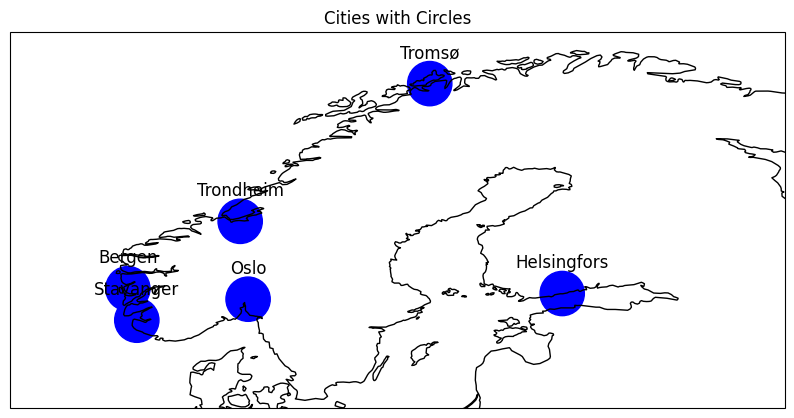

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Latitude and Longitude coordinates for 5 cities
cities = {
    "Oslo": (59.9139, 10.7522),
    "Bergen": (60.3913, 5.3221),
    "Trondheim": (63.4305, 10.3951),
    "Tromsø": (69.6496, 18.9560),
    "Stavanger": (58.9650, 5.7268),
    "Helsingfors": (60.1699, 24.9384),
}

# Plot city locations
# Create a map with Cartopy and GeoAxes, focused on the Nordic region
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=15, central_latitude=65))

ax.set_extent([0, 35, 55, 72], crs=ccrs.PlateCarree())

# Plot city locations
for city, (lat, lon) in cities.items():
    ax.text(lon, lat+1, city, fontsize=12, ha="center", va="bottom")

# Plot circles around the cities
for city, (lat, lon) in cities.items():
    ax.add_patch(plt.Circle((lon, lat), 1, transform=ccrs.PlateCarree(), color="b", fill=True))

# Customize the map
ax.coastlines()
# ax.gridlines()
# Show the map
plt.title("Cities with Circles")
plt.show()
